# Importing all necessary classes and libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from GS_algorithm_first_iteration import gsw_output
from GS_algorithm2 import *
from SLM_Control import *
from showSLMPreview import showSLMPreview
from dcam_live_capturing import *
from beam_locator import *
import time
import cv2

# SLM Initialization

Make sure that the SLM Preview window is open

In [2]:
slm = SLMControler()

# Initialize camera and capture the background intensity 

### Camera Initialization

For debugging or if the camera initialization returns error. Try running the HCImageLive software to check if the camera can be detected and viewed. Try running the cell again after the software is closed.

Make sure that the HCImageLive software is closed since it can not run concurrently with the python code

In [3]:
dcam_capture = DcamLiveCapturing(iDevice = 0)

### Background intensity

Block the coupling laser before you take the measurement

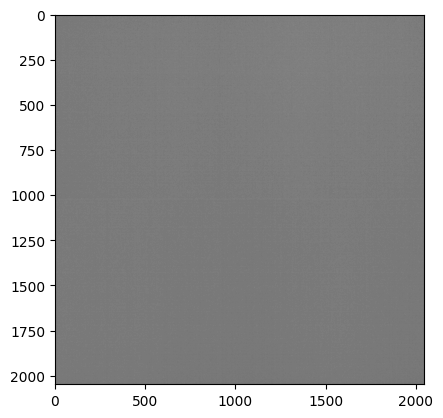

In [5]:
background = dcam_capture.capture_single_frame()

# displaying the background image
plt.imshow(background, cmap='gray')

# Beam Locating

### First iteration of GSW without feedback

This part is used to locate the beams using the beam locator class

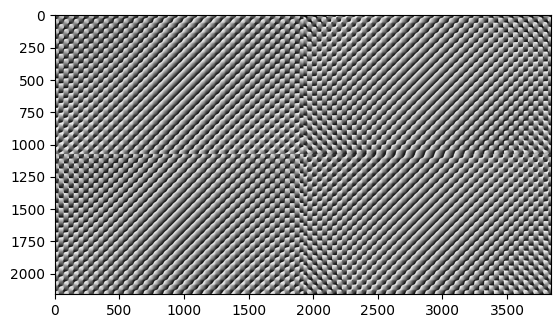

In [6]:
### Initilization ###
# for the light beams 
number_of_rows = 2
number_of_columns = 2

# for the phase pattern 
part_rows = 2
part_columns = 2
# to define a normal distribution of weights depending on the number of rows and columns
# weight = np.ones(number_of_columns * number_of_rows) / (number_of_columns * number_of_rows)

# since we are only using this part to get the LOCATION of the beams, we don't need to specify the weights
weight = np.array([0.25, 0.25, 0.25, 0.25])

# beam waist size
w0 = 10

# distances between each light beams
interval = 200

# the error allowed for which the algorithm to start saving the phase patterns
# if the error is less than the error_allowed, the algorithm will save the phase pattern in the desired file location
error_allowed = 0.12

Dim = np.array([part_rows, part_columns])
#####################

# size_real = np.array([1920, 1080]) 
# using the HOLOEYE GAEA-2, the resolution is 3840 x 2160
size_real = np.array([3840, 2160])
Overall_Pattern = np.zeros((2160, 3840), dtype=np.float64)

size_real = size_real / Dim 
size_real = size_real.astype(int)
temp = np.zeros(number_of_columns * number_of_rows)
temp[:len(weight)] = weight
weight_shaped = np.reshape(temp, (number_of_columns, number_of_rows))
weight_shaped = np.flipud(weight_shaped)

Pattern1 = np.zeros((2160, 3840), dtype=np.float64)

total_part_num = part_rows * part_columns

for part in range(1, total_part_num + 1):
    for iteration in range (0, 5):
        # since there is no feedback in this part, the balance is set to 0
        balance = 0
        if iteration == 0:
            [Pattern_part, phi] = gsw_output(size_real, weight_shaped, interval, number_of_rows, number_of_columns, w0, 0)
            Pattern_last = phi
        else:
            [Pattern_part, phi] = gs_iteration_modified(size_real, weight_shaped, interval, Pattern_last, balance, w0)
            Pattern_last = phi

    
    x = int(Dim[0] - 1 - np.mod(part - 1, Dim[0]))
    y = int(np.floor((part - 1) / Dim[0]))  

    start_x = x * size_real[0]
    end_x = (x+1) * size_real[0]
    start_y = y * size_real[1]
    end_y = (y+1) * size_real[1]
 
    Pattern1[start_y : end_y, start_x : end_x] = Pattern_part

# divide each value in Pattern by 2 * pi
Pattern1 = np.mod(Pattern1, 2 * np.pi)

# displaying the phase pattern
plt.imshow(Pattern1, cmap='gray')

### Run the beam locator to find the locations of all beams

Loading the beam locator class and display the generated pattern on the SLM

In [7]:
class beam_locator:
    def __init__(self, image, number_of_rows, number_of_cols):
        self.image = image
        self.cursor_locations = [(1000, 100), (1700, 100), (200, 200), (100, 1700)]  # Initialize cursor locations
        self.dragging = False
        self.current_cursor = None
        self.crosshair_length = 40  # Set the length of the crosshair lines
        self.rows = number_of_rows
        self.cols = number_of_cols
        # initialize all the beam corners
        self.total_num_beams = self.rows * self.cols
        self.beam_corners = np.zeros((self.total_num_beams, 2, 2), dtype=float)

    def draw_crosshair(self, img, center):
        # Draw vertical line
        cv2.line(img, (center[0], center[1] - self.crosshair_length // 2),
                 (center[0], center[1] + self.crosshair_length // 2), (0, 255, 0), 2)
        # Draw horizontal line
        cv2.line(img, (center[0] - self.crosshair_length // 2, center[1]),
                 (center[0] + self.crosshair_length // 2, center[1]), (0, 255, 0), 2)

    def display_image_with_crosshairs(self):
        cv2.namedWindow('Image with Crosshairs', cv2.WINDOW_NORMAL)  # Resizable window

        while True:
            img = self.image.copy()

            # Normalize the image to uint8 if it is uint16
            if img.dtype == np.uint16:
                img = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))

            if len(img.shape) == 2:  # Check if the image is grayscale
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

            # Draw crosshairs at cursor locations
            for loc in self.cursor_locations:
                self.draw_crosshair(img, loc)

            cv2.imshow('Image with Crosshairs', img)

            # Set mouse callback function
            cv2.setMouseCallback('Image with Crosshairs', self.mouse_callback)

            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break

        cv2.destroyAllWindows()

    def mouse_callback(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            # Check if cursor is clicked
            for idx, loc in enumerate(self.cursor_locations):
                if abs(loc[0] - x) < self.crosshair_length // 2 and abs(loc[1] - y) < self.crosshair_length // 2:
                    self.dragging = True
                    self.current_cursor = idx
                    break
        elif event == cv2.EVENT_MOUSEMOVE:
            # Update cursor location if dragging
            if self.dragging:
                self.cursor_locations[self.current_cursor] = (x, y)

        elif event == cv2.EVENT_LBUTTONUP:
            # Stop dragging
            self.dragging = False
            self.current_cursor = None

    def get_cursor_locations(self):
        # sort the cursor locations in the following order, top left, top right, bottom left, bottom right
        self.cursor_locations = sorted(self.cursor_locations, key=lambda x: x[0])
        self.cursor_locations = sorted(self.cursor_locations, key=lambda x: x[1])

        return self.cursor_locations

    def calculate_all_beam_locations(self):
        # from the first and third elements of the cursor_locations list, we can calculate the diameter of a beam
        # the first element of the array is the top left of the beam and the third element represents the bottom right corner of the beam
        self.beam_diameter = np.sqrt((self.cursor_locations[2][0] - self.cursor_locations[0][0])**2 + (self.cursor_locations[2][1] - self.cursor_locations[0][1])**2)
        print("Beam Diameter:", self.beam_diameter)

        # from the first and second element of the list, these are the top left corners of the top left most and top right most beams
        # find the horizontal intervals of all beams
        self.horizontal_intervals = (self.cursor_locations[1][0] - self.cursor_locations[0][0]) / (self.cols - 1)
        # now to find the vertical intervals
        self.vertical_intervals = (self.cursor_locations[3][1] - self.cursor_locations[0][1]) / (self.rows - 1)

        self.horizontal_rise = (self.cursor_locations[1][1] - self.cursor_locations[0][1]) / (self.cols - 1)
        self.vertical_shift = (self.cursor_locations[3][0] - self.cursor_locations[0][0]) / (self.rows - 1)

        # now from these horizontal and vertical intervals, we can calculate the top left corners of all 25 beams and create a box using the diameter calculated as well
        # store the corners in a 25 x 4 array, for each beam, store the four corners of the box

        # Iterate over the rows
        for i in range(self.rows):
            # Iterate over the columns
            for j in range(self.cols):
                # Calculate the top left corner of the current box
                top_left = [self.cursor_locations[0][0] + j * self.horizontal_intervals + i * self.vertical_shift, self.cursor_locations[0][1] + i * self.vertical_intervals + j * self.horizontal_rise]
                
                # Calculate the bottom right corner
                bottom_right = [top_left[0] + self.beam_diameter, top_left[1] + self.beam_diameter]
                
                # Store the corners in the array
                self.beam_corners[i * self.rows + j] = [top_left, bottom_right]

Display the generated phase pattern and capture a single frame image which will then be used for the beam locator.

In [8]:
slm.display_data(Pattern1)

# put a sleep timer to make sure the SLM has enough time to display the pattern
time.sleep(1)

captured_image = dcam_capture.capture_single_frame()

# show the captured image using the plt function
plt.imshow(captured_image, cmap='gray')

Drag the cursors to the top left, bottom right corner of the top left beam; the top left corner of the top right beam; and the top left corner of the bottom left beam. After you have placed the cursors in the appropriate locations, pressure "q" on the keyboard to close the window. 

In [10]:
# Check if an image was captured
if captured_image is not None:
    # # Create a resizable window
    # cv2.namedWindow("Captured Image", cv2.WINDOW_NORMAL)

    # # Display the captured image using OpenCV
    # cv2.imshow("Captured Image", captured_image)
    
    # while True:
    #     if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty("Captured Image", cv2.WND_PROP_VISIBLE) < 1:
    #         break
    # cv2.destroyAllWindows()  # Close the window

    locator = beam_locator(captured_image, number_of_rows, number_of_columns)

    # Display image with crosshairs and allow user interaction
    locator.display_image_with_crosshairs()

    # Get cursor locations
    cursor_locations = locator.get_cursor_locations()

    locator.calculate_all_beam_locations()

    beam_corners = locator.beam_corners

    # store them in a file
    with open("beam_corners.txt", "w") as f:
        for loc in beam_corners:
            top_left, bottom_right = loc
            f.write(f"{top_left[0]}, {top_left[1]}, {bottom_right[0]}, {bottom_right[1]}\n")
else:
    print("No image captured.")

Beam Diameter: 40.496913462633174


To double check that all the beam corners have been calculated. these values can also be read in the beam_corner.txt file in the directory

In [11]:
# for debugging purposes
print("Beam Corners:", beam_corners)

Beam Corners: [[[ 897.          892.        ]
  [ 937.49691346  932.49691346]]

 [[1065.          896.        ]
  [1105.49691346  936.49691346]]

 [[ 894.         1063.        ]
  [ 934.49691346 1103.49691346]]

 [[1062.         1067.        ]
  [1102.49691346 1107.49691346]]]


### Function to measure the intensity of each beam

In [12]:
image = captured_image - background

def measure_greyscale_intensity(image, beam_corners):
    """
    Measures the grayscale intensity inside the rectangles described by the coordinates in beam_corners.

    Parameters:
    image (numpy.ndarray): The input image.
    beam_corners (list): A list of tuples, where each tuple contains two pairs of coordinates
                         (top-left and bottom-right) of a beam.

    Returns:
    intensities (list): A list of average grayscale intensities for each beam.
    """
    intensities = []

    for top_left, bottom_right in beam_corners:
        x1, y1 = map(int, top_left)
        x2, y2 = map(int, bottom_right)
        roi = image[y1:y2, x1:x2]
        average_intensity = np.mean(roi)
        intensities.append(average_intensity)

    return intensities

# for testing purposes
# Measure the grayscale intensity inside the rectangles described by the beam corners
measured_intensities = measure_greyscale_intensity(image, beam_corners)

print("Grayscale Intensities for Each Beam:")
for idx, intensity in enumerate(measured_intensities):
    print(f"Beam {idx + 1}: {intensity}")

Grayscale Intensities for Each Beam:
Beam 1: 43678.356875
Beam 2: 14762.4475
Beam 3: 6965.561875
Beam 4: 9405.22875


### Function used to place the generated phase pattern in respective location in the overall phase pattern

In [13]:
def pattern_placement(part, Pattern, Pattern_part):
    x = int(Dim[0] - 1 - np.mod(part - 1, Dim[0]))
    y = int(np.floor((part - 1) / Dim[0]))  

    start_x = x * size_real[0]
    end_x = (x+1) * size_real[0]
    start_y = y * size_real[1]
    end_y = (y+1) * size_real[1]
 
    Pattern[start_y : end_y, start_x : end_x] = Pattern_part
    return Pattern

### Rescale the beam intensities

In [16]:
rescale = 2e-5

In [17]:
# scale down the measured intensities
intensities = [intensity * rescale for intensity in measured_intensities]

# print out the intensities
print("Scaled Down Intensities:")
for idx, intensity in enumerate(intensities):
    print(f"Beam {idx + 1}: {intensity}")

# calculate the std error
std_error = np.std(np.abs(weight - intensities))
print("std Error:", std_error)

# calculate the mean error
mean_error = np.mean(np.abs(weight - intensities))
print("mean Error:", mean_error)

Scaled Down Intensities:
Beam 1: 0.00017471342750000003
Beam 2: 5.9049790000000004e-05
Beam 3: 2.7862247500000002e-05
Beam 4: 3.7620915000000005e-05
std Error: 5.8771163301514594e-05
mean Error: 0.24992518840499997


### Running the GSW algorithm

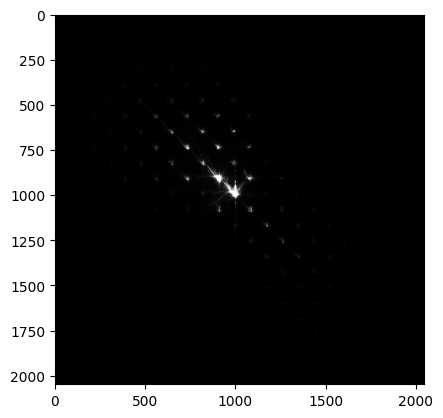

In [18]:
captured_image = dcam_capture.capture_single_frame()

# show the captured image using the plt function
plt.imshow(captured_image, cmap='gray')

Part: 1
Grayscale Intensities for Each Beam: [0.53858353 0.00838064 0.01007276 0.03231695]
Error: 0.6408167639817173
std Error: 0.02582459879708099
Mean Error: 0.24695329375
Average Grayscale Intensities for Each Beam: [0.53426677 0.00828146 0.00966158 0.03262678]
Error: 0.5876080290773459
std Error: 0.024156778088608884
Mean Error: 0.245924240625
Average Grayscale Intensities for Each Beam: [0.53200094 0.00832362 0.00996227 0.03404409]
Error: 0.5387579318955152
std Error: 0.02370797324966427
Mean Error: 0.2449177375
Average Grayscale Intensities for Each Beam: [0.53130899 0.00826331 0.00964714 0.03346211]
Error: 0.49379120688274686
std Error: 0.02324154957295887
Mean Error: 0.24498410625
Average Grayscale Intensities for Each Beam: [0.53542045 0.00832488 0.01009053 0.03286749]
Error: 0.45297475532744963
std Error: 0.024713852494330276
Mean Error: 0.24603439062500002
Average Grayscale Intensities for Each Beam: [0.53685603 0.00831531 0.00982404 0.03263505]
Error: 0.4156161538594278
std

KeyboardInterrupt: 

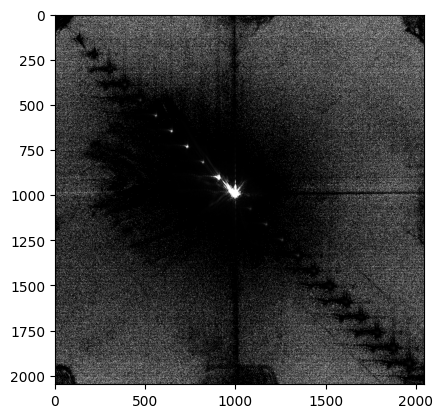

In [20]:
error = 0.01

def error_calculation (Wt, Wm, Wc, e):
    """
    Function to perform the weight iteration process.

    Parameters:
    Wt (numpy.ndarray): Array representing the original weight matrix.
    Wm (numpy.ndarray): Array representing the measured weights.
    Wc (numpy.ndarray): Array representing the corrected weights.
    e (float): Error term.

    Returns:
    W_next (numpy.ndarray): The updated W_next array.
    e_next (float): The updated error term.
    """
    a = 0.8
    b = 0.2
    # Ensure Wt and Wc are the same length as Wm
    Wt = Wt[:len(Wm)]
    Wc = Wc[:len(Wm)]

    # Replace negative values in Wm with 0.001
    Wm = np.where(Wm < 0, 0.001, Wm)

    # Calculate the next corrected weight matrix
    temp = np.sqrt(a * Wt / Wm + (1 - a)) * Wc
    temp[Wt == 0] = 0
    W_next = temp


    # Calculate e_next
    if e == 0:
        # First time iteration
        e_next = -np.sum(Wt) + np.sum(Wm)

        e_next = np.sqrt(abs(e_next))
    else:
        # Several times iteration
        e_next = (b * np.sum(Wm) / np.sum(Wt) + (1 - b)) * e

    return W_next, e_next

# for part in range(1, 145):
for part in range(1,5):
    print("Part:", part)

    # for each part, we are only concerned with that specific part and the rest of the phase pattern would be zero
    # so we first initialize a phase pattern with all zeros
    Pattern = np.zeros((2160, 3840), dtype=np.float64)

    # maximum of 80 iterations
    for iteration in range (0, 81):
        W_next = np.array([0.25, 0.25, 0.25, 0.25])
        if iteration == 0:
            [Pattern_part, phi] = gsw_output(size_real, weight_shaped, interval, number_of_rows, number_of_columns, w0, 0)
            Pattern_last = phi

            # placing the pattern at the correct location on the whole SLM phase pattern
            Pattern = pattern_placement(part, Pattern, Pattern_part)   
            Pattern = np.mod(Pattern, 2 * np.pi)

            # now we want to display the pattern on the SLM and capture an image of it
            slm.display_data(Pattern)

            # time delay of 1 seconds 
            time.sleep(1)

            # capture an image of the SLM
            captured_image = dcam_capture.capture_single_frame()
            
            time.sleep(1)

            # subtract the background image from the captured image
            captured_image = captured_image - background
            
            # calculate the intensity of each beam using the locations found and stored in a file
            measured_intensities = measure_greyscale_intensity(captured_image, beam_corners)
            # scale down the measured intensities
            intensities = np.array([intensity * rescale for intensity in measured_intensities])
            print("Grayscale Intensities for Each Beam:", intensities)

            W_next, error = error_calculation(weight, intensities, W_next, error)

            temp = np.zeros(number_of_columns * number_of_rows)
            temp[:len(weight)] = W_next
            weight_shaped = np.reshape(temp, (number_of_columns, number_of_rows))
            weight_shaped = np.flipud(weight_shaped)

            print("Error:", error)

            # calculate the std error
            std_error = np.std(np.abs(weight - intensities))
            print("std Error:", std_error)

            # calculate the mean error
            mean_error = np.mean(np.abs(weight - intensities))
            print("Mean Error:", mean_error)

        else:
            [Pattern_part, phi] = gs_iteration_modified(size_real, weight_shaped, interval, Pattern_last, error, w0)
            Pattern_last = phi

            Pattern = pattern_placement(part, Pattern, Pattern_part)

            Pattern = np.mod(Pattern, 2 * np.pi)

            # now we want to display the pattern on the SLM and capture an image of it
            slm.display_data(Pattern)

            # time delay of 1 seconds 
            time.sleep(1)

            # capture an image of the SLM
            captured_image = dcam_capture.capture_single_frame()

            time.sleep(1)
            
            # subtract the background image from the captured image
            captured_image = captured_image - background

            # calculate the intensity of each beam using the locations found and stored in a file
            measured_intensities = measure_greyscale_intensity(captured_image, beam_corners)

            # scale down the measured intensities
            intensities = np.array([intensity * rescale for intensity in measured_intensities])
            print("Average Grayscale Intensities for Each Beam:", intensities)

            W_next, error = error_calculation(weight, intensities, W_next, error)
            
            temp = np.zeros(number_of_columns * number_of_rows)
            temp[:len(weight)] = W_next
            weight_shaped = np.reshape(temp, (number_of_columns, number_of_rows))
            weight_shaped = np.flipud(weight_shaped)

            print("Error:", error)

            # calculate the std error
            std_error = np.std(np.abs(weight - intensities))
            print("std Error:", std_error)

            # calculate the mean error
            mean_error = np.mean(np.abs(weight - intensities))
            print("Mean Error:", mean_error)